In [1]:
import sys 
assert (sys.version_info.major == 3) and (sys.version_info.minor == 9)

In [2]:
import importlib
from utils import *
utils = importlib.import_module('utils')
importlib.reload(utils)

<module 'utils' from '/Users/subnaulitus/Documents/EPFL/Master/MA2/EE-451/IAPR-project/project/utils.py'>

Load reference images and plot them with contours

In [5]:
ref_dir = 'chocolate-recognition-classic/references/'
ref_image_names = [f for f in os.listdir(ref_dir) if f.endswith('.JPG')]
ref_images = [cv2.imread(os.path.join(ref_dir, img)) for img in ref_image_names]
ref_images = [cv2.resize(img, (img.shape[1] // 4, img.shape[0] // 4)) for img in ref_images]
ref_images_rgb = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in ref_images]
ref_images_gray = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in ref_images]

In [6]:
bbox_sizes = []
bbox_coords = []
reference_feature_vectors = []

for i, gray in enumerate(ref_images_gray):
    mean, std = np.mean(gray), np.std(gray)
    k1, k2 = 4.5, 4.3
    lower = int(max(0, mean - k1 * std))
    upper = int(min(255, mean + k2 * std))
    
    thresh = np.where((gray < lower) | (gray > upper), 255, 0).astype(np.uint8)
    binary = img_as_bool(thresh)
    blurred = cv2.GaussianBlur(binary.astype(np.uint8), (7, 7), 0)
    cleaned = remove_small_objects(blurred, min_size=100)
    cleaned = remove_small_holes(cleaned, area_threshold=1000)
    processed = (cleaned * 255).astype(np.uint8)

    contours = find_contours(thresh.T)
    if not contours:
        print(f"Warning: No contour found in {ref_image_names[i]}")
        continue

    interpolated = linear_interpolation([contours[0]], n_samples=80)[0]

    img_copy = ref_images[i].copy()
    mask = np.zeros(img_copy.shape[:2], dtype=np.uint8)

    if interpolated.shape[0] > 0:
        interpolated_int = np.round(interpolated).astype(np.int32)
        cv2.fillPoly(mask, [interpolated_int], 255)
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
        mask = cv2.erode(mask, kernel, iterations=1)

        ys, xs = np.where(mask > 0)
        x_min, x_max = xs.min(), xs.max()
        y_min, y_max = ys.min(), ys.max()

        bbox_size = (y_max - y_min, x_max - x_min)
        bbox_sizes.append(bbox_size)
        bbox_coords.append((y_min, y_max, x_min, x_max))

min_height = min([h for h, w in bbox_sizes])
min_width = min([w for h, w in bbox_sizes])
min_size = (min_height, min_width)

reference_feature_vectors = []
new_bbox_coords = []

for i, gray in enumerate(ref_images_gray):
    mean, std = np.mean(gray), np.std(gray)
    k1, k2 = 4.5, 4.3
    lower = int(max(0, mean - k1 * std))
    upper = int(min(255, mean + k2 * std))
    
    thresh = np.where((gray < lower) | (gray > upper), 255, 0).astype(np.uint8)
    binary = img_as_bool(thresh)
    blurred = cv2.GaussianBlur(binary.astype(np.uint8), (3, 3), 0)
    cleaned = remove_small_objects(blurred, min_size=100)
    cleaned = remove_small_holes(cleaned, area_threshold=1000)
    processed = (cleaned * 255).astype(np.uint8)

    contours = find_contours(thresh.T)
    if not contours:
        print(f"Warning: No contour found in {ref_image_names[i]}")
        continue

    interpolated = linear_interpolation([contours[0]], n_samples=80)[0]

    img_copy = ref_images[i].copy()
    mask = np.zeros(img_copy.shape[:2], dtype=np.uint8)

    if interpolated.shape[0] > 0:
        interpolated_int = np.round(interpolated).astype(np.int32)
        cv2.fillPoly(mask, [interpolated_int], 255)
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
        mask = cv2.erode(mask, kernel, iterations=1)

        ys, xs = np.where(mask > 0)
        x_min, x_max = xs.min(), xs.max()
        y_min, y_max = ys.min(), ys.max()

        center_x = (x_min + x_max) // 2
        center_y = (y_min + y_max) // 2

        half_w = min_size[1] // 2
        half_h = min_size[0] // 2

        new_x_min = max(0, center_x - half_w)
        new_x_max = min(ref_images[i].shape[1], center_x + half_w)
        new_y_min = max(0, center_y - half_h)
        new_y_max = min(ref_images[i].shape[0], center_y + half_h)

        new_bbox_coords.append((new_y_min, new_y_max, new_x_min, new_x_max))

        roi = ref_images[i][new_y_min:new_y_max, new_x_min:new_x_max]
        roi_mask = mask[new_y_min:new_y_max, new_x_min:new_x_max]

        roi_resized = cv2.resize(roi, (min_size[1], min_size[0]))
        roi_mask_resized = cv2.resize(roi_mask, (min_size[1], min_size[0]), interpolation=cv2.INTER_NEAREST)

        ref_vec = extract_masked_features(roi_resized, roi_mask_resized, feature_list=None)
        reference_feature_vectors.append(ref_vec)


/var/folders/7j/8bv4knb942dghg0vr1lnkc_r0000gp/T/ipykernel_50700/3780019182.py:14: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  cleaned = remove_small_objects(blurred, min_size=100)
/var/folders/7j/8bv4knb942dghg0vr1lnkc_r0000gp/T/ipykernel_50700/3780019182.py:15: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  cleaned = remove_small_holes(cleaned, area_threshold=1000)
/var/folders/7j/8bv4knb942dghg0vr1lnkc_r0000gp/T/ipykernel_50700/3780019182.py:58: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  cleaned = remove_small_objects(blurred, min_size=100)
/var/folders/7j/8bv4knb942dghg0vr1lnkc_r0000gp/T/ipykernel_50700/3780019182.py:59: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  cleaned = remove_small_holes(cleaned, area_threshold=1000)


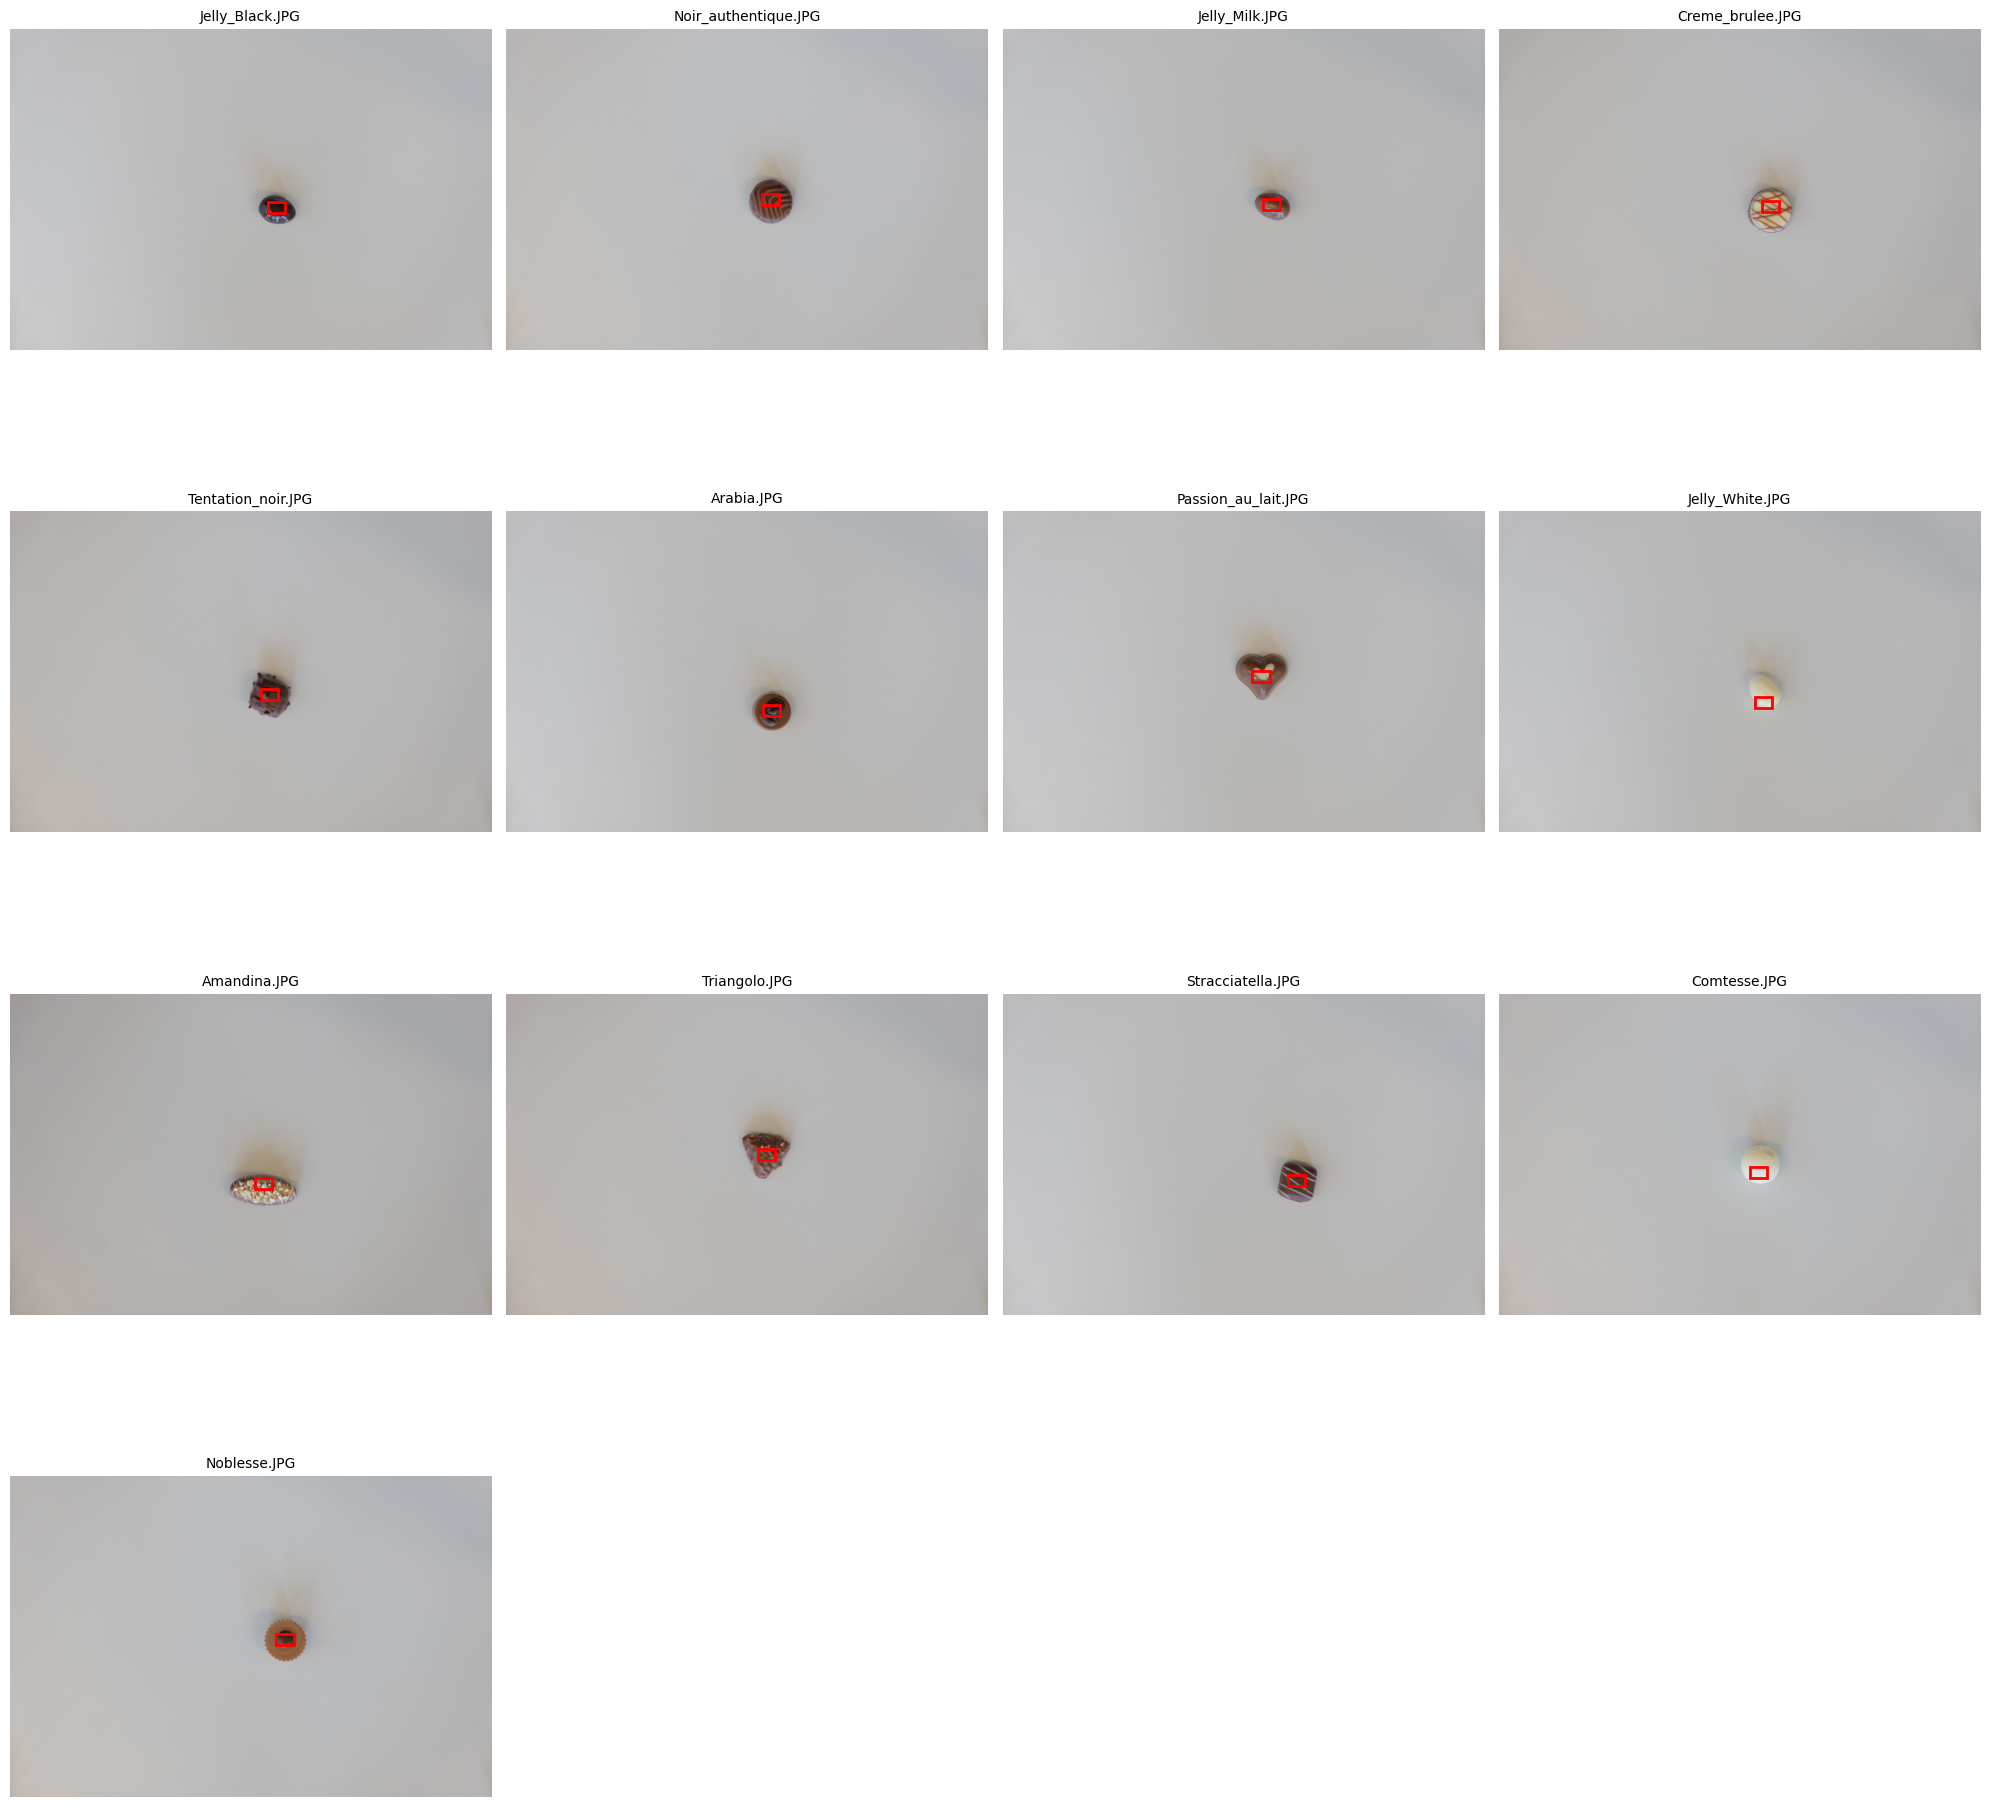

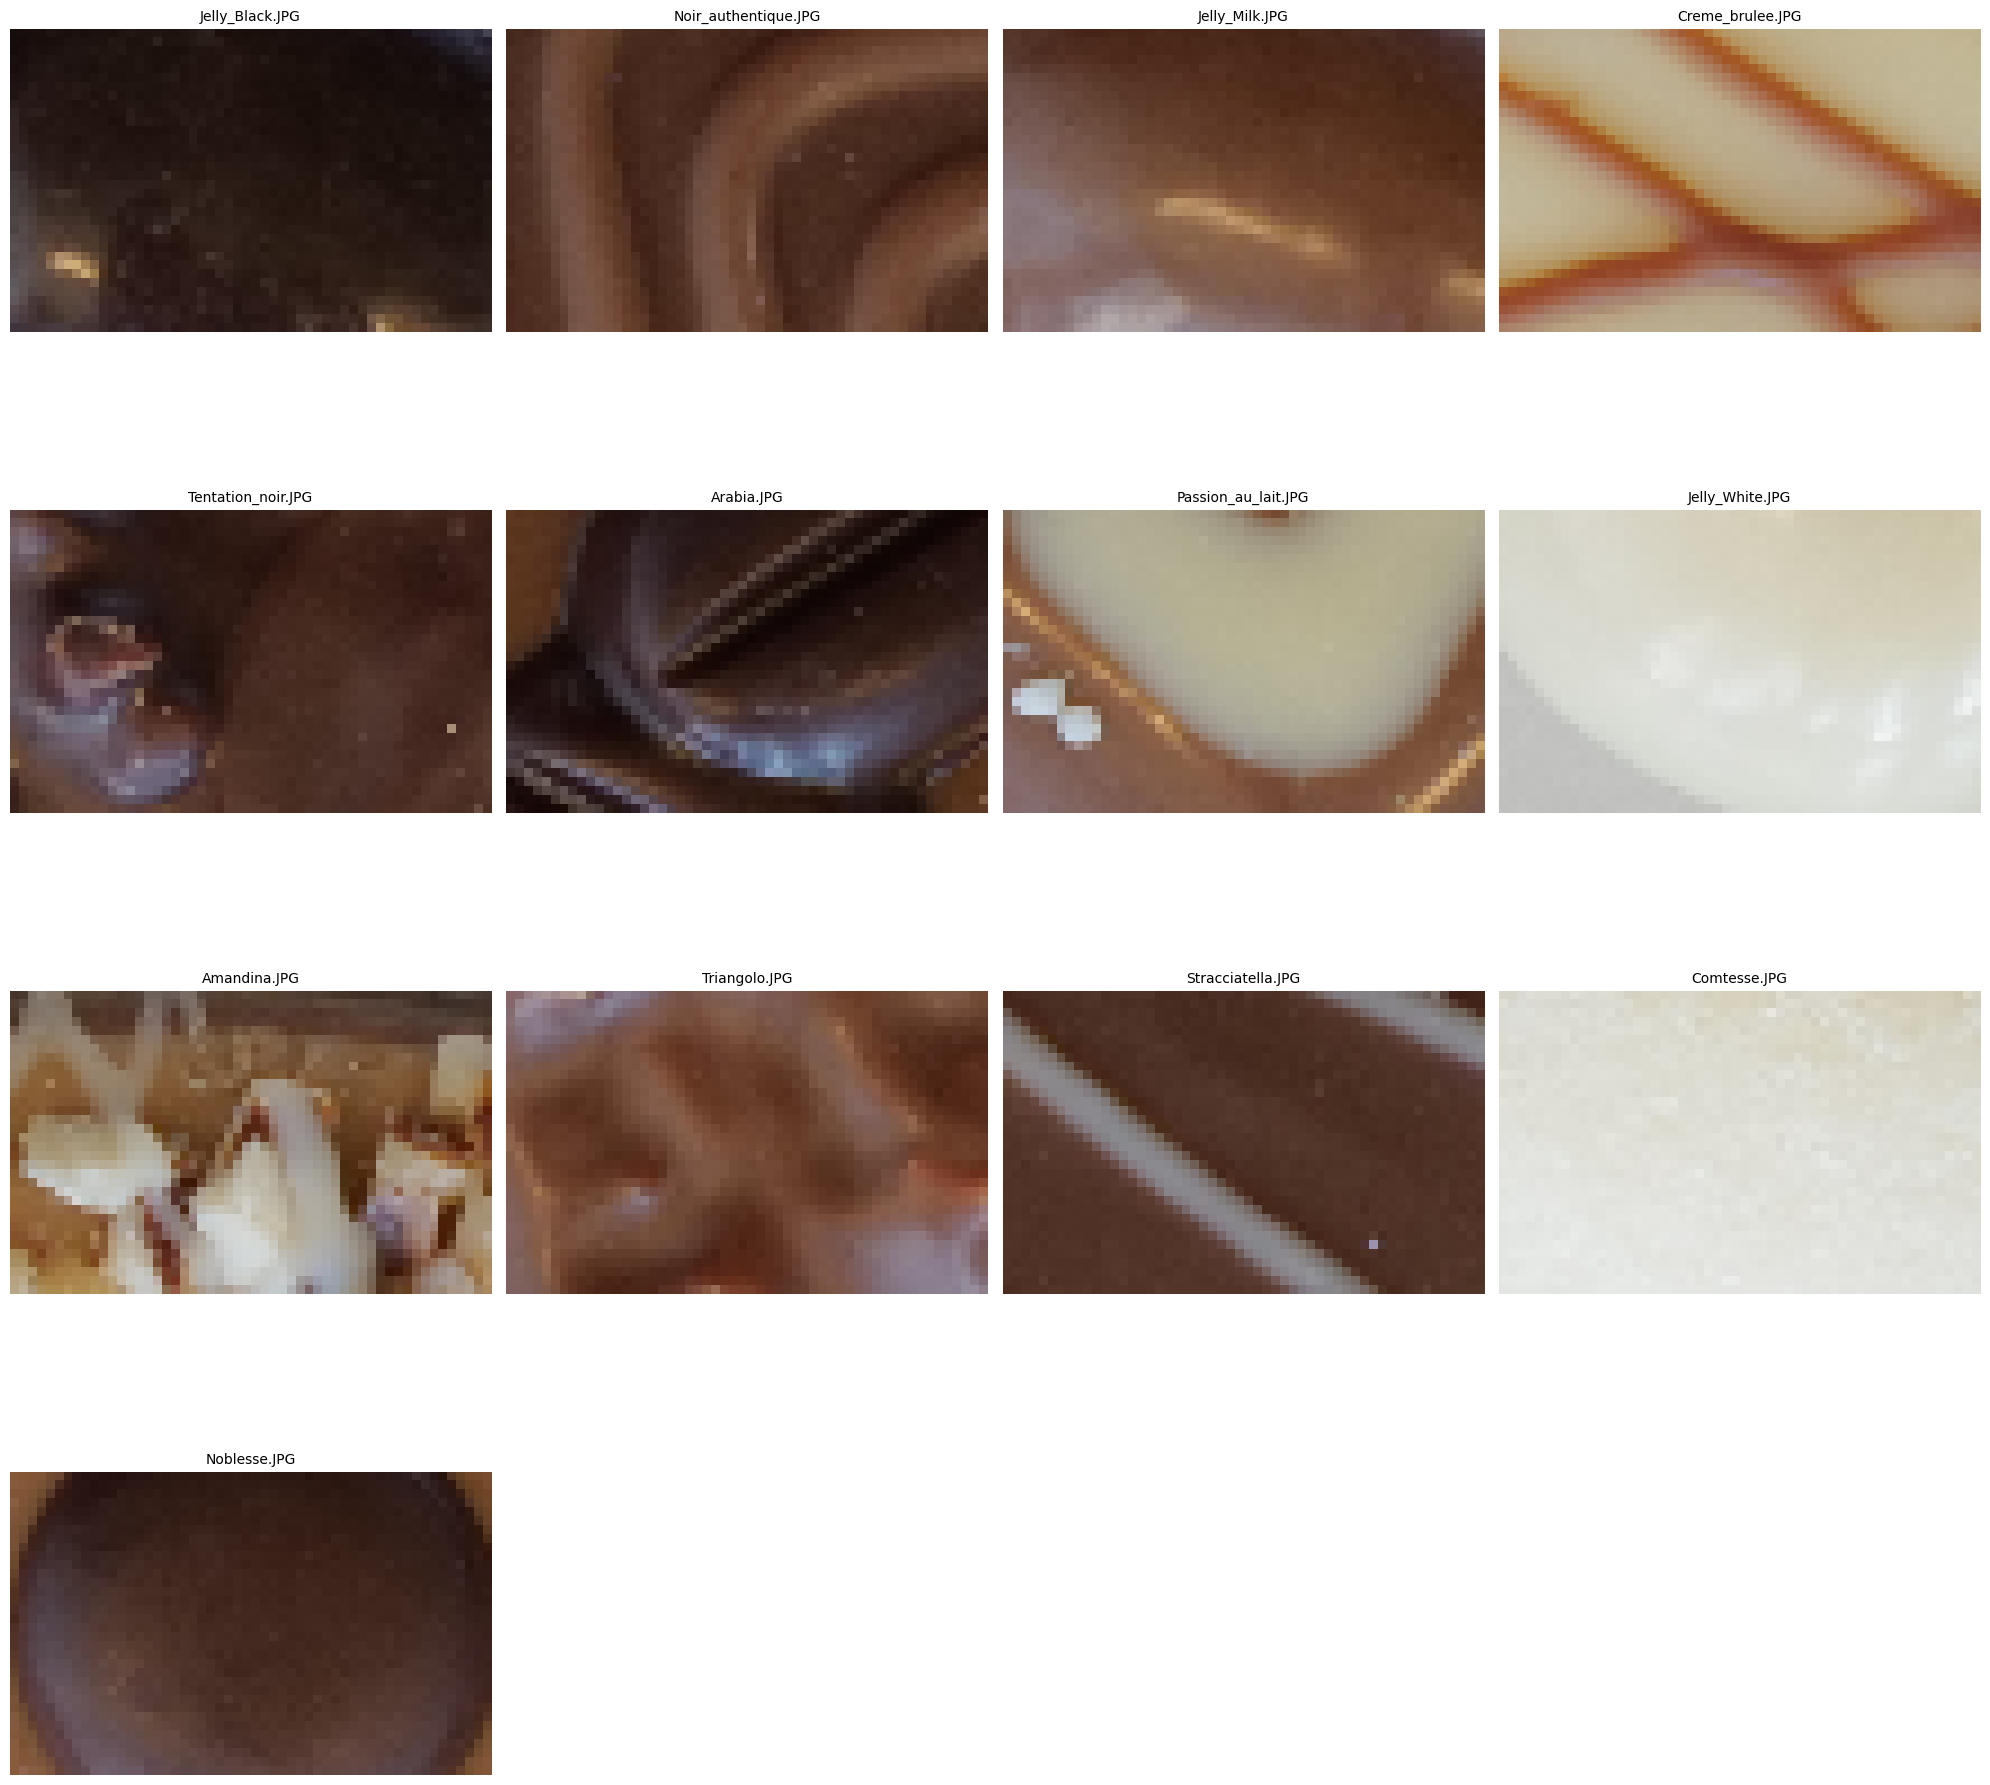

In [7]:
cols = 4
rows = int(np.ceil(len(ref_image_names) / cols))
plt.figure(figsize=(5 * cols, 5 * rows))

for i, img_name in enumerate(ref_image_names):
    img = cv2.cvtColor(ref_images[i], cv2.COLOR_BGR2RGB)

    y_min, y_max, x_min, x_max = new_bbox_coords[i]
    box_width = x_max - x_min
    box_height = y_max - y_min

    ax = plt.subplot(rows, cols, i + 1)
    ax.imshow(img)

    rect = patches.Rectangle((x_min, y_min), box_width, box_height,
                             linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

    ax.set_title(img_name, fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

cols = 4
rows = int(np.ceil(len(ref_image_names) / cols))
plt.figure(figsize=(5 * cols, 5 * rows))

for i, img_name in enumerate(ref_image_names):
    y_min, y_max, x_min, x_max = new_bbox_coords[i]
    roi = ref_images[i][y_min:y_max, x_min:x_max]
    roi_rgb = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)

    ax = plt.subplot(rows, cols, i + 1)
    ax.imshow(roi_rgb)
    ax.set_title(img_name, fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

# save image patches to a list
for i, img_name in enumerate(ref_image_names):
    y_min, y_max, x_min, x_max = new_bbox_coords[i]
    roi = ref_images[i][y_min:y_max, x_min:x_max]
    roi_rgb = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
    # make sure the directory exists
    os.makedirs('chocolate-recognition-classic/reference-patches', exist_ok=True)
    cv2.imwrite(f'chocolate-recognition-classic/reference-patches/{img_name}', roi_rgb)

/var/folders/7j/8bv4knb942dghg0vr1lnkc_r0000gp/T/ipykernel_50700/1232891399.py:23: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  cleaned = remove_small_objects(blurred, min_size=100)
/var/folders/7j/8bv4knb942dghg0vr1lnkc_r0000gp/T/ipykernel_50700/1232891399.py:24: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  cleaned = remove_small_holes(cleaned, area_threshold=1000)


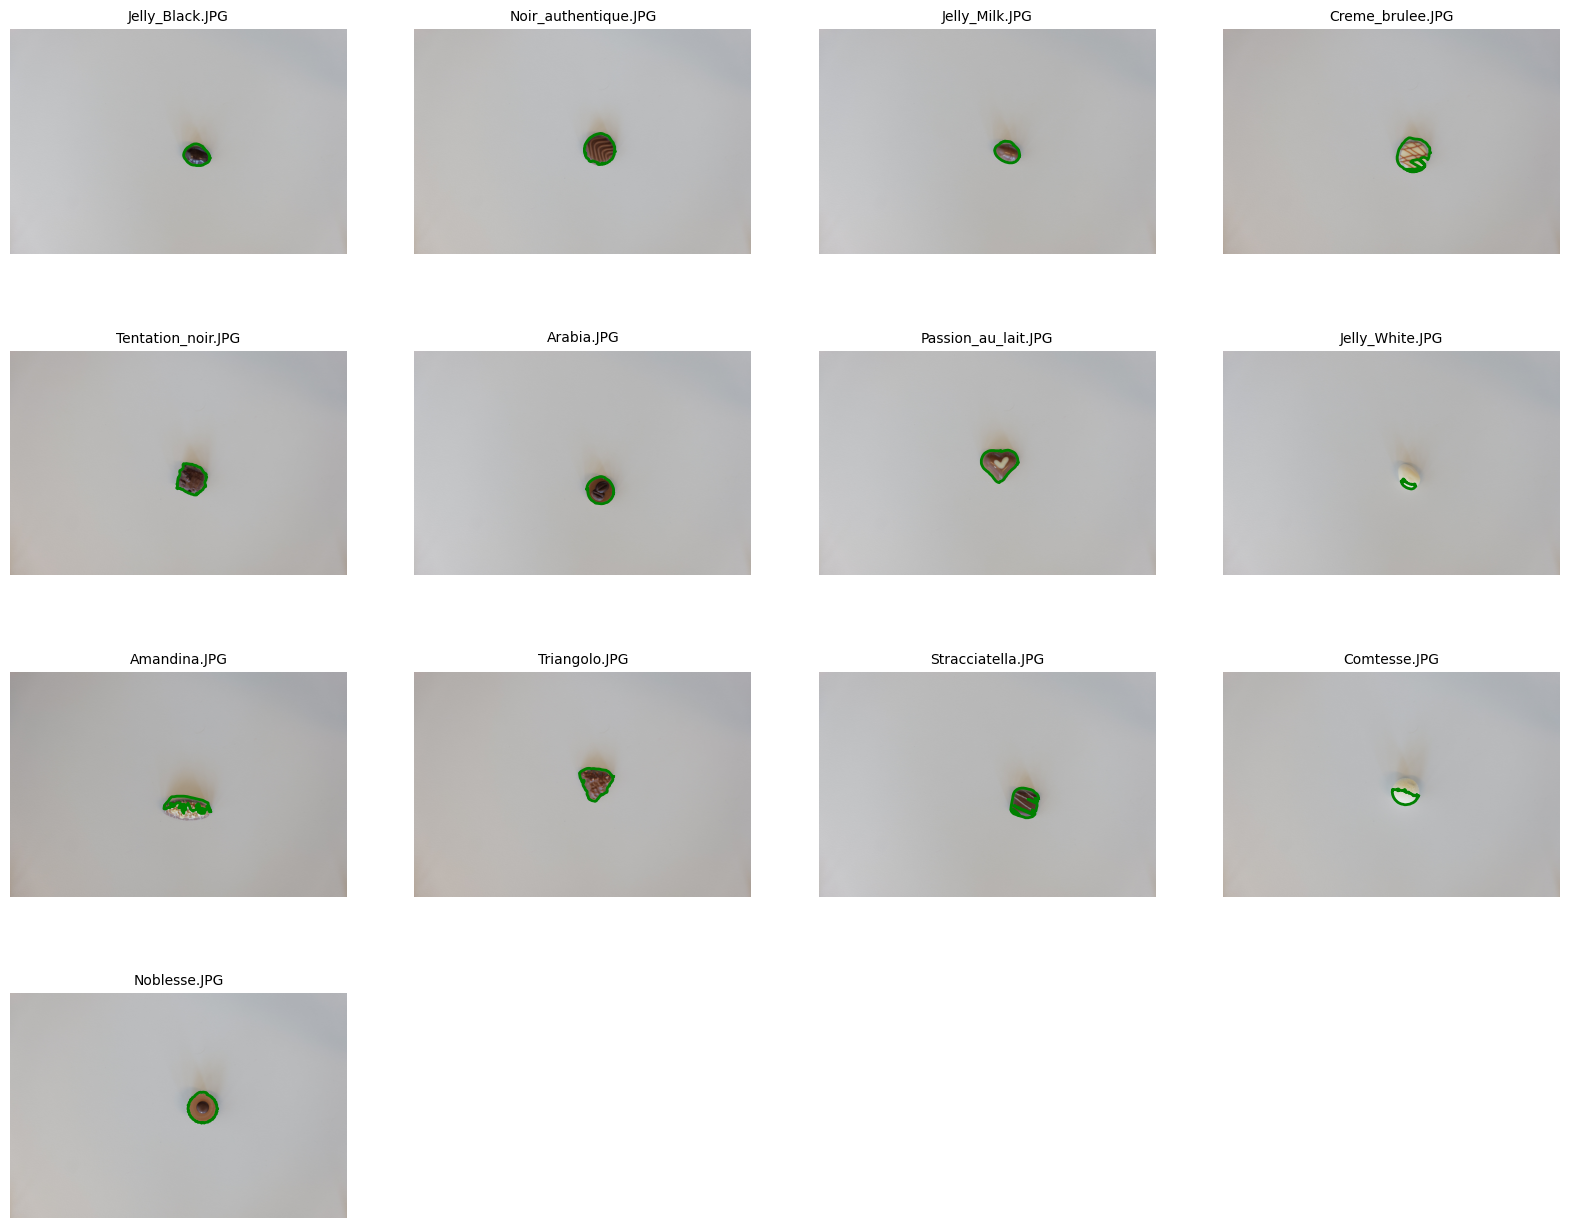

In [8]:
reference_histograms = [] # used for sliding window
contours_all = [] 

cols = 4
rows = int(np.ceil(len(ref_image_names) / cols))
plt.figure(figsize=(20, 4 * rows))

for i, gray in enumerate(ref_images_gray):

    # Thresholding
    mean = np.mean(gray)
    std = np.std(gray)
    k1 = 4.5
    k2 = 4.3
    lower = int(max(0, mean - k1 * std))
    upper = int(min(255, mean + k2 * std))

    thresh = np.where((gray < lower) | (gray > upper), 255, 0).astype(np.uint8)

    # Morphological cleaning
    binary = img_as_bool(thresh)
    blurred = cv2.GaussianBlur(binary.astype(np.uint8), (7, 7), 0)
    cleaned = remove_small_objects(blurred, min_size=100)
    cleaned = remove_small_holes(cleaned, area_threshold=1000)
    processed = (cleaned * 255).astype(np.uint8)

    # Find contours
    contour = find_contours(thresh.T)[0]
    interpolated = linear_interpolation([contour], n_samples=80)[0]

    # Calculate histogram inside the contour
    img_copy = ref_images_rgb[i].copy()
    mask = np.zeros(img_copy.shape[:2], dtype=np.uint8)

    if interpolated.shape[0] > 0:
        interpolated_int = np.round(interpolated).astype(np.int32)
        cv2.fillPoly(mask, [interpolated_int], 255)

        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))  
        mask = cv2.erode(mask, kernel, iterations=1) # make contour smaller to make sure we don't include the background by using morphological erosion

        hist = cv2.calcHist([img_copy], [0, 1, 2], mask, [16, 16, 16], [0, 256]*3)
        
    hist = cv2.normalize(hist, hist).flatten()
    reference_histograms.append(hist)

    plt.subplot(rows, cols, i + 1)

    plt.imshow(img_copy, cmap='gray')
    plt.plot(interpolated[:, 0], interpolated[:, 1], 'g-', linewidth=2)

    plt.title(ref_image_names[i], fontsize=10)
    plt.axis('off')

Load training data

In [ ]:
train_dir = 'chocolate-recognition-classic/train/'
train_image_names = [f for f in os.listdir(train_dir) if f.endswith('.JPG')]
train_images = [cv2.imread(os.path.join(train_dir, train_image_names[i])) for i in range(len(train_image_names))]
train_images = [cv2.resize(img, (img.shape[1] // 4, img.shape[0] // 4)) for img in train_images]
train_images_rgb = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in train_images]
train_images_gray = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in train_images]

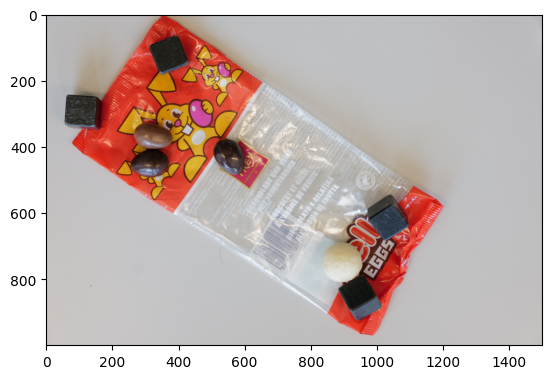

In [14]:
plt.imshow(train_images_rgb[10])
plt.show()

Apply sliding window to the training data

In [15]:
window_size = 50
stride = 10

percentile = 97.3

heatmaps= []
for img in train_images_rgb:
    heatmap = sliding_window_compare(img, reference_histograms, window_size=window_size, stride=stride)
    threshold = np.percentile(heatmap, percentile)
    heatmap = np.where(heatmap >= threshold, heatmap, 0)
    heatmaps.append(heatmap)

Detect number of hotspots

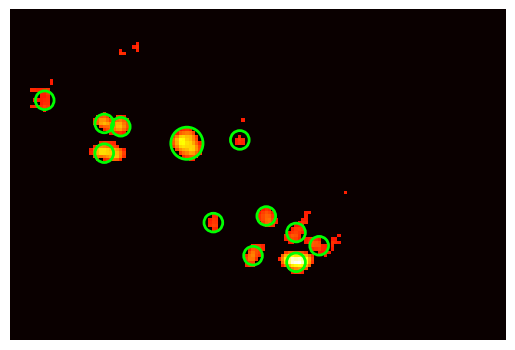

In [19]:
from skimage.feature import blob_log

blobs = []
for heatmap in heatmaps:
    blobs.append(blob_log(heatmap, min_sigma=2, max_sigma=15, threshold=0.1))

plt.imshow(heatmaps[10], cmap='hot')
for y, x, r in blobs[10]:
    c = plt.Circle((x, y), r * np.sqrt(2), color='lime', linewidth=2, fill=False)
    plt.gca().add_patch(c)
plt.axis('off')
plt.show()

Extract patches around the detected hotspots

In [122]:
patches_ = []
for img, blob in zip(train_images_rgb, blobs):
    patches_.append(extract_patches_from_blobs(img, blob, stride=stride, window_size=window_size))

In [123]:
resized_patches = []
for patch in patches_:
    resized_patch = []
    for p in patch:
        rp = cv2.resize(p, (min_size[1], min_size[0])) 
        resized_patch.append(rp)
    resized_patches.append(resized_patch)

Calculate some descriptors for the patches

In [124]:
patch_features = []
features = []
for i, patch in enumerate(resized_patches):
    feature = []
    for p in patch:
        feature.append(extract_features(p, feature_list=None))
    patch_features.append(feature)

(4343,)
True


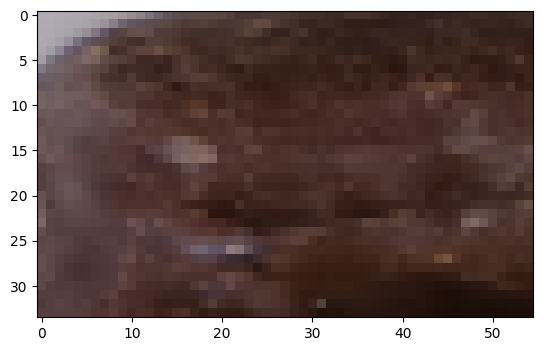

In [126]:
print(patch_features[0][0].shape)
print(len(patch_features)==len(train_image_names))

plt.imshow(resized_patches[10][0])

In [127]:
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

k = 30 # 13 minimum

# Flatten patch features for clustering
patch_features_flat = np.vstack([np.array(pf) for pf in patch_features])

# Cluster the feature vectors of the training patches
kmeans = KMeans(n_clusters=k)
kmeans.fit(patch_features_flat)

cluster_labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

# Find closest reference image for each cluster center
closest_cluster_idx, _ = pairwise_distances_argmin_min(reference_feature_vectors, cluster_centers)

# Cluster to reference mapping
cluster_to_reference = dict()
for ref_idx, cluster_idx in enumerate(closest_cluster_idx):
    cluster_to_reference[cluster_idx] = ref_idx

# Assign labels to training patches based on cluster label
final_patch_labels = []
for cl in cluster_labels:
    if cl in cluster_to_reference:
        ref_idx = cluster_to_reference[cl]
        label = ref_image_names[ref_idx]
    else:
        label = None
    final_patch_labels.append(label)

final_patch_labels = np.array(final_patch_labels)

# Map back to per-image patch labels if you want:
patch_labels_per_image = []
start = 0
for patches in patch_features:
    n_patches = len(patches)
    patch_labels_per_image.append(final_patch_labels[start:start+n_patches])
    start += n_patches

from collections import Counter
print("Label distribution in training patches:")
print(Counter(final_patch_labels))

Label distribution in training patches:
Counter({None: 821, 'Jelly_Milk.JPG': 32, 'Jelly_Black.JPG': 26, 'Noblesse.JPG': 20, 'Comtesse.JPG': 20, 'Arabia.JPG': 13, 'Noir_authentique.JPG': 13, 'Creme_brulee.JPG': 7, 'Tentation_noir.JPG': 6, 'Jelly_White.JPG': 1})


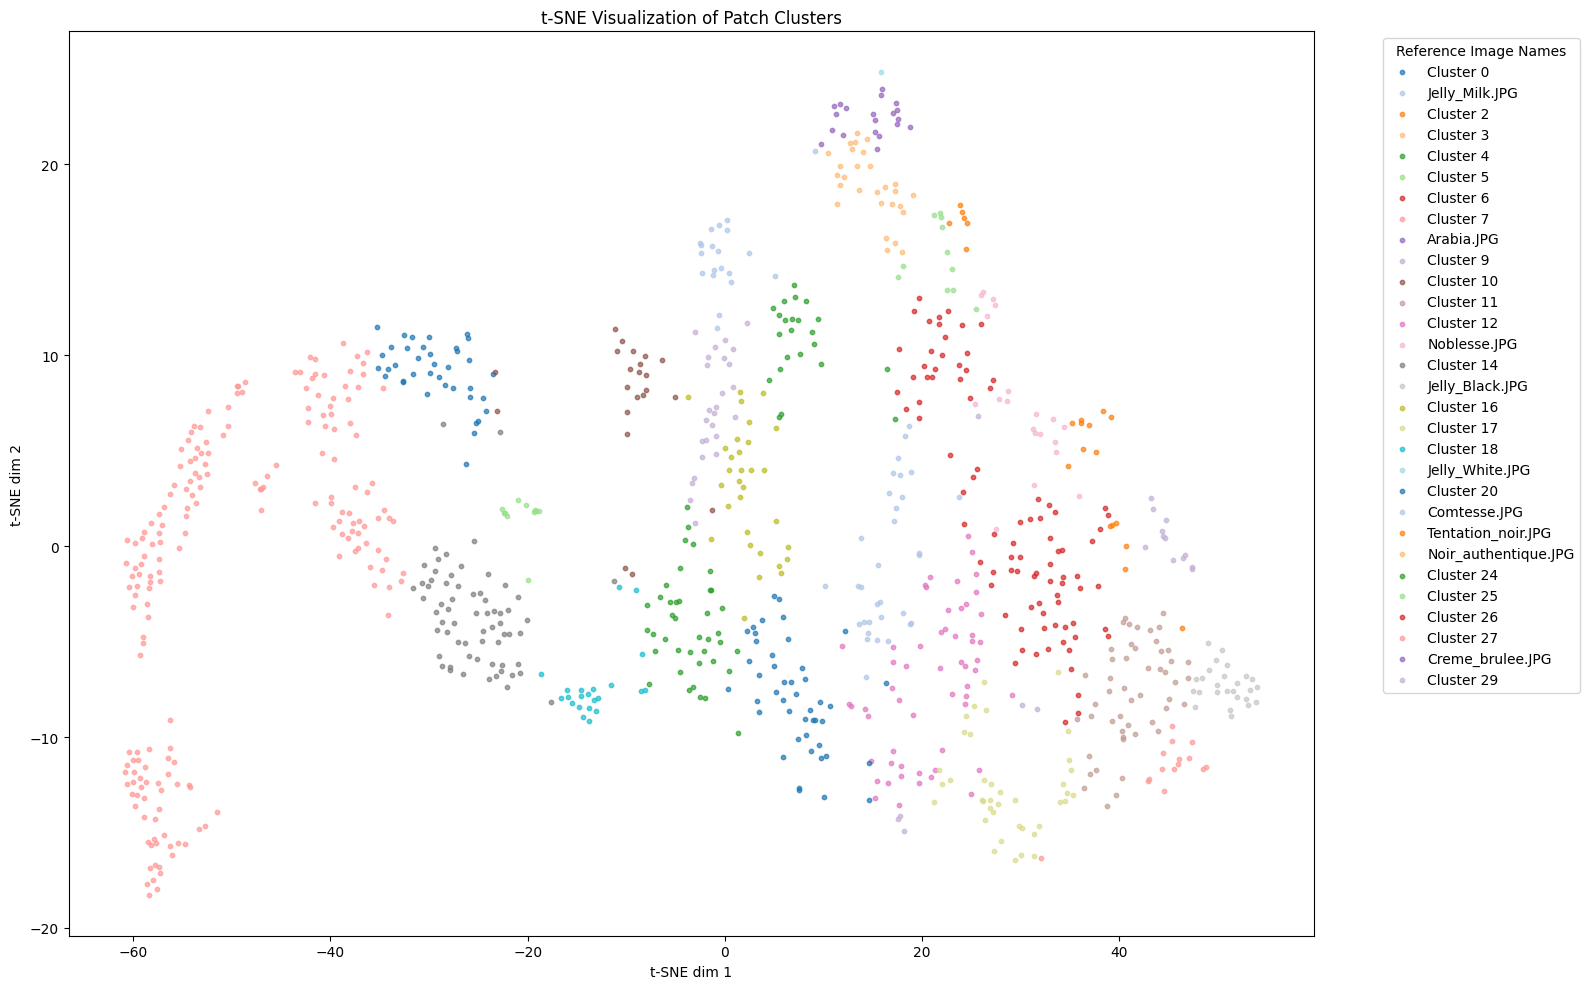

In [128]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
patches_2d = tsne.fit_transform(patch_features_flat)

plt.figure(figsize=(16, 10))

unique_clusters = np.unique(cluster_labels)
colors = plt.cm.tab20.colors

for i, cluster_id in enumerate(unique_clusters):
    idx = cluster_labels == cluster_id
    
    # Get the reference image name for this cluster, or fallback label
    label = cluster_to_reference.get(cluster_id, None)
    if label is not None:
        cluster_label_name = ref_image_names[label]
    else:
        cluster_label_name = f'Cluster {cluster_id}'
    
    plt.scatter(patches_2d[idx, 0], patches_2d[idx, 1], 
                color=colors[i % len(colors)], s=10, alpha=0.7, label=cluster_label_name)

plt.xlabel('t-SNE dim 1')
plt.ylabel('t-SNE dim 2')
plt.title('t-SNE Visualization of Patch Clusters')
plt.legend(title='Reference Image Names', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Cross-validate the descriptors

ground_truth = 0